In [ ]:
!pip install tensorflow

# Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dataloader import load_data, getData

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "drive/My Drive/ZIP_FILES/lungimg.zip" -d "Dataset" | head -n 5
dataset_path = "Dataset"

Mounted at /content/drive


In [ ]:
image_path = os.path.join(dataset_path, "Lung Segmentation","CXR_png")
mask_path = os.path.join(dataset_path, "Lung Segmentation","masks")
images = os.listdir(image_path)
mask = os.listdir(mask_path)

In [ ]:
""" Global parameters """
H = 512
W = 512

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


if __name__ == "__main__":

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """

    num_epochs = 50
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

# Seeing the dataset split

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path,split=0.1)
''''''
print(f"Train: {len(train_x)} - {len(train_y)} ")
print(f"Valid: {len(valid_x)} - {len(valid_y)} ")
print(f"Test: {len(test_x)} - {len(test_y)} ")

Train: 564 - 564 
Valid: 70 - 70 
Test: 70 - 70 


In [ ]:

training_files = list(zip(train_x, train_y))
testing_files=list(zip(test_x, test_y))
validation_files=list(zip(valid_x, valid_y))



In [ ]:

def plotMask(X,y):
    sample = []

    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)


    for i in range(0,6,3):

        plt.figure(figsize=(25,10))

        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])

        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])


        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])

        plt.show()

In [ ]:
dim=512
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim,flag="test")
X_val,y_val=getData(dim,flag="val")

100%|██████████| 70/70 [00:12<00:00,  5.76it/s]


# Checking images and masks correspondence

## Training set check

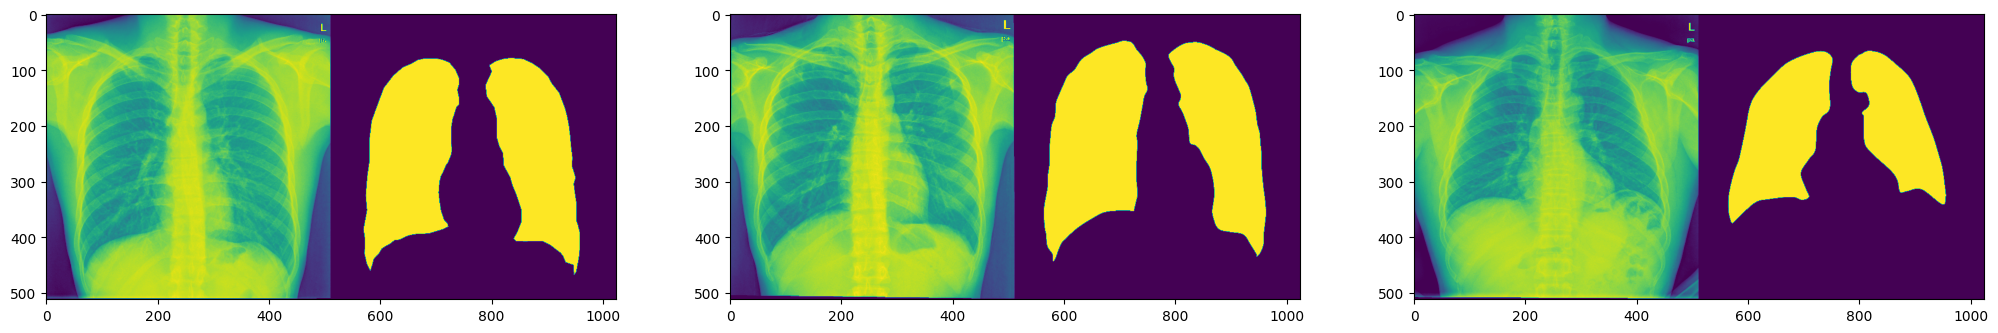

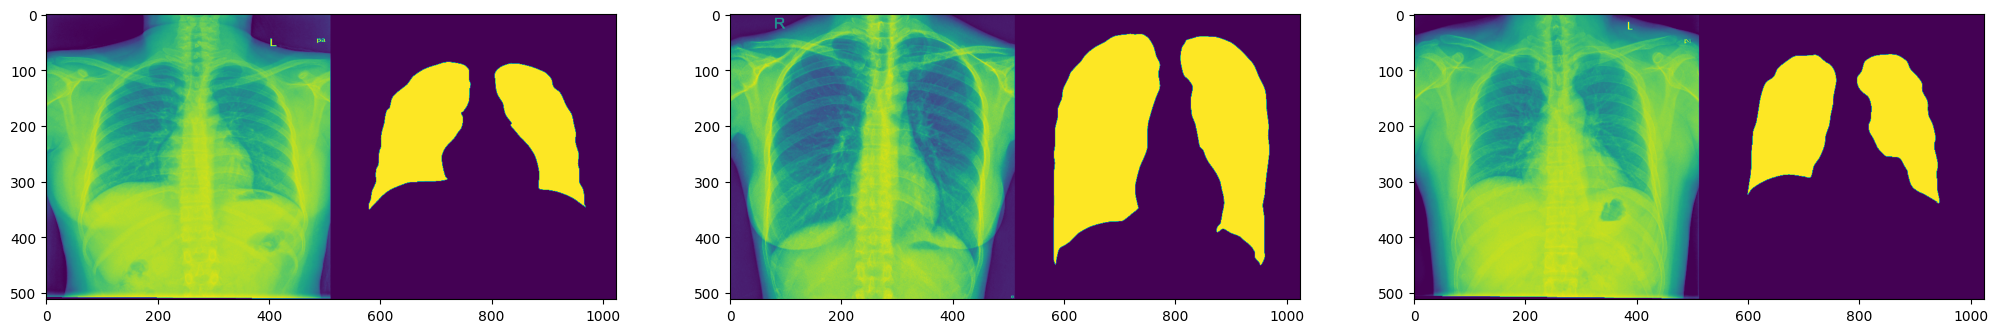

In [ ]:
plotMask(X_train,y_train)

## Test set check

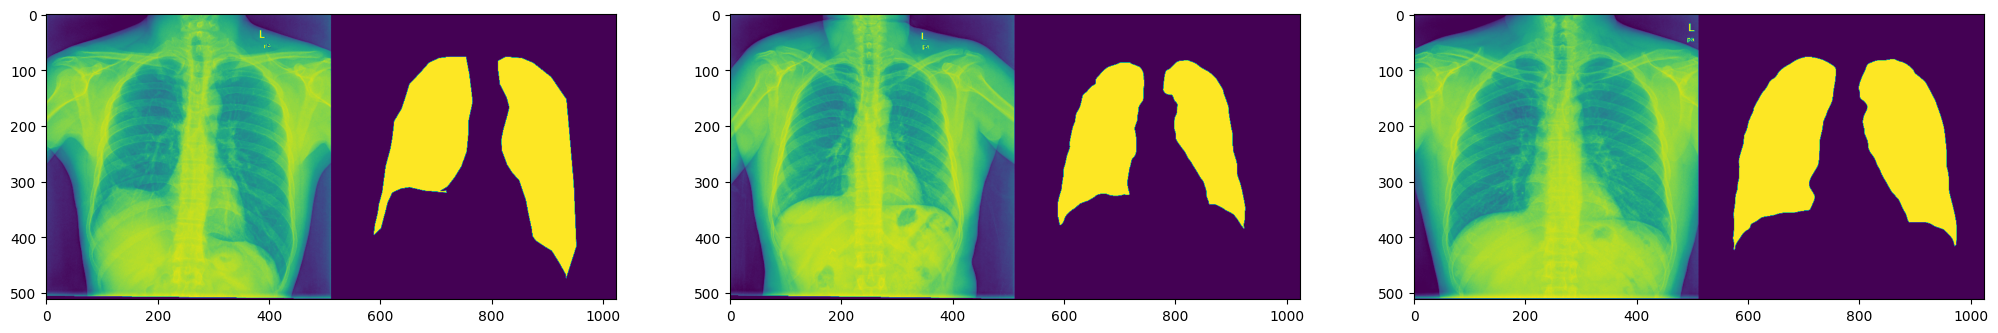

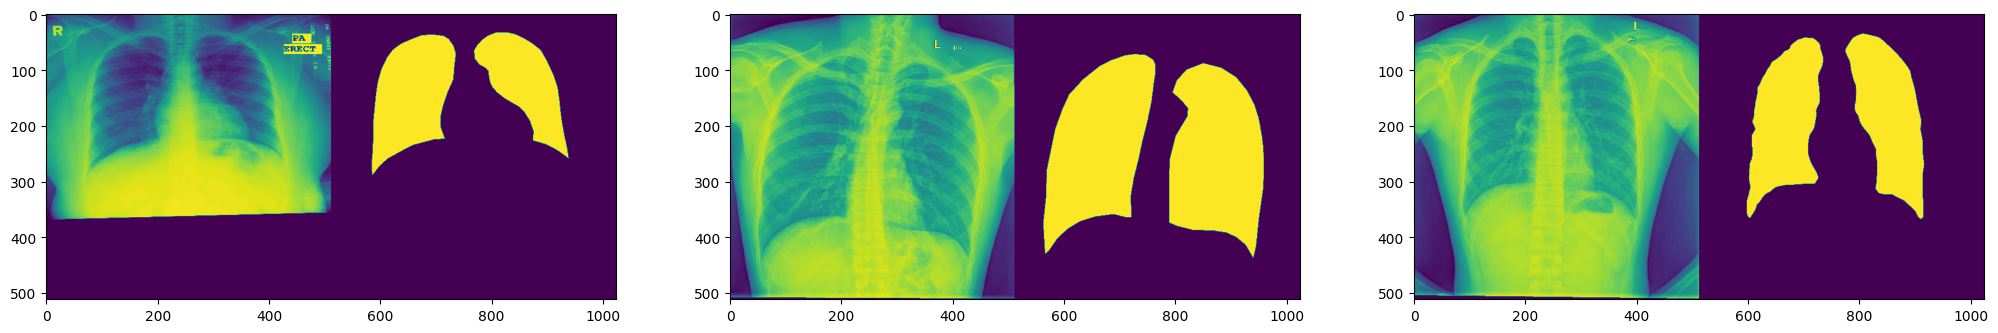

In [ ]:
plotMask(X_test,y_test)

## Validation set check

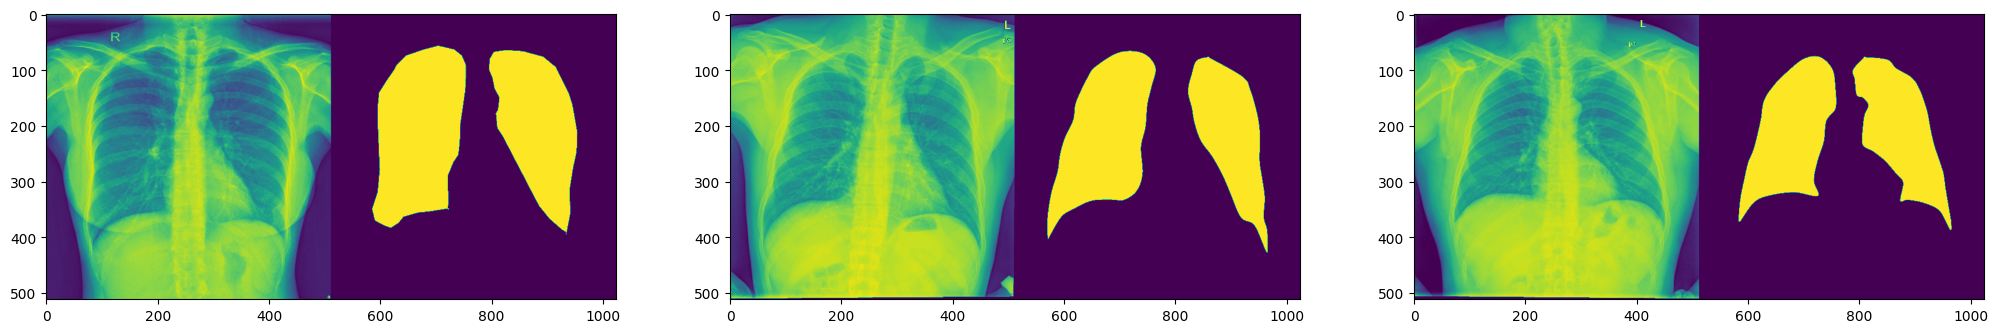

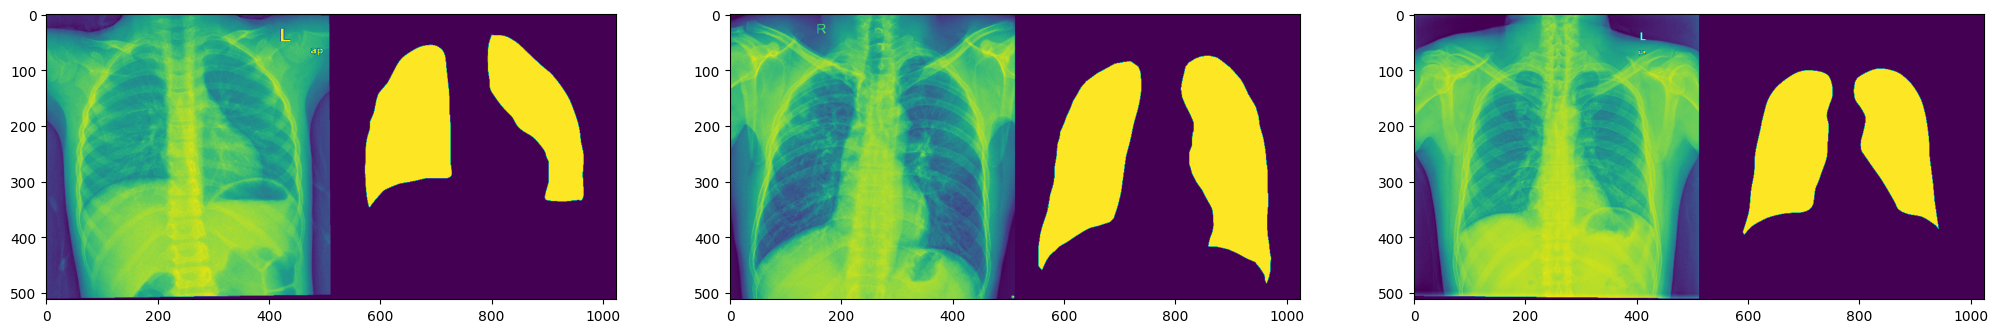

In [ ]:
plotMask(X_val,y_val)

In [ ]:
dim=512
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
X_val=np.array(X_val).reshape(len(X_val),dim,dim,1)
y_val=np.array(y_val).reshape(len(y_val),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
assert X_val.shape== y_val.shape
#images = np.concatenate((X_train,X_test,X_val),axis=0)
#mask  = np.concatenate((y_train,y_test,y_val),axis=0)

# Defining loss functions

In [ ]:
import tensorflow as tf
import numpy as np

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = tf.cast(x, tf.float32)
    return x


In [ ]:

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from model import unet
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


if __name__ == "__main__":
    input_shape = (512, 512, 1)
    model = unet(input_shape)
    model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 512, 512, 32  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_115 (Conv2D)            (None, 512, 512, 32  9248        ['conv2d_114[0][0]']             
                                )                                                           

# Training the model

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
model = unet((512, 512, 1))

model.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy',iou])



/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

# Compile the model
model.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
              metrics=[dice_coef, 'binary_accuracy', iou])



# Preprocess the data
train_vol = (np.array(X_train) - 127.0) / 127.0
train_seg = (np.array(y_train) > 0.5).astype(np.float32)

validation_vol = (np.array(X_val) - 127.0) / 127.0
validation_seg = (np.array(y_val) > 0.5).astype(np.float32)

test_vol = (np.array(X_test) - 127.0) / 127.0
test_seg = (np.array(y_test) > 0.5).astype(np.float32)

# Train the model
loss_history = model.fit(
    x=train_vol,
    y=train_seg,
    batch_size=16,
    epochs=50,
    validation_data=(validation_vol, validation_seg),
    callbacks=callbacks_list
)


Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: -0.4813 - dice_coef: 0.4819 - binary_accuracy: 0.5919 - iou: 0.3209
Epoch 1: val_loss improved from inf to -0.58164, saving model to cxr_reg_weights.best.hdf5
36/36 [==============================] - 46s 1s/step - loss: -0.4813 - dice_coef: 0.4819 - binary_accuracy: 0.5919 - iou: 0.3209 - val_loss: -0.5816 - val_dice_coef: 0.5786 - val_binary_accuracy: 0.6651 - val_iou: 0.4075 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: -0.5489 - dice_coef: 0.5472 - binary_accuracy: 0.6447 - iou: 0.3784
Epoch 2: val_loss did not improve from -0.58164
36/36 [==============================] - 40s 1s/step - loss: -0.5489 - dice_coef: 0.5472 - binary_accuracy: 0.6447 - iou: 0.3784 - val_loss: -0.5725 - val_dice_coef: 0.5697 - val_binary_accuracy: 0.6607 - val_iou: 0.3988 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: -0.5808 - dice_coef: 0.5797 - binary_accuracy: 0.6909

# Predicted masks on test set

3/3 [==============================] - 1s 610ms/step


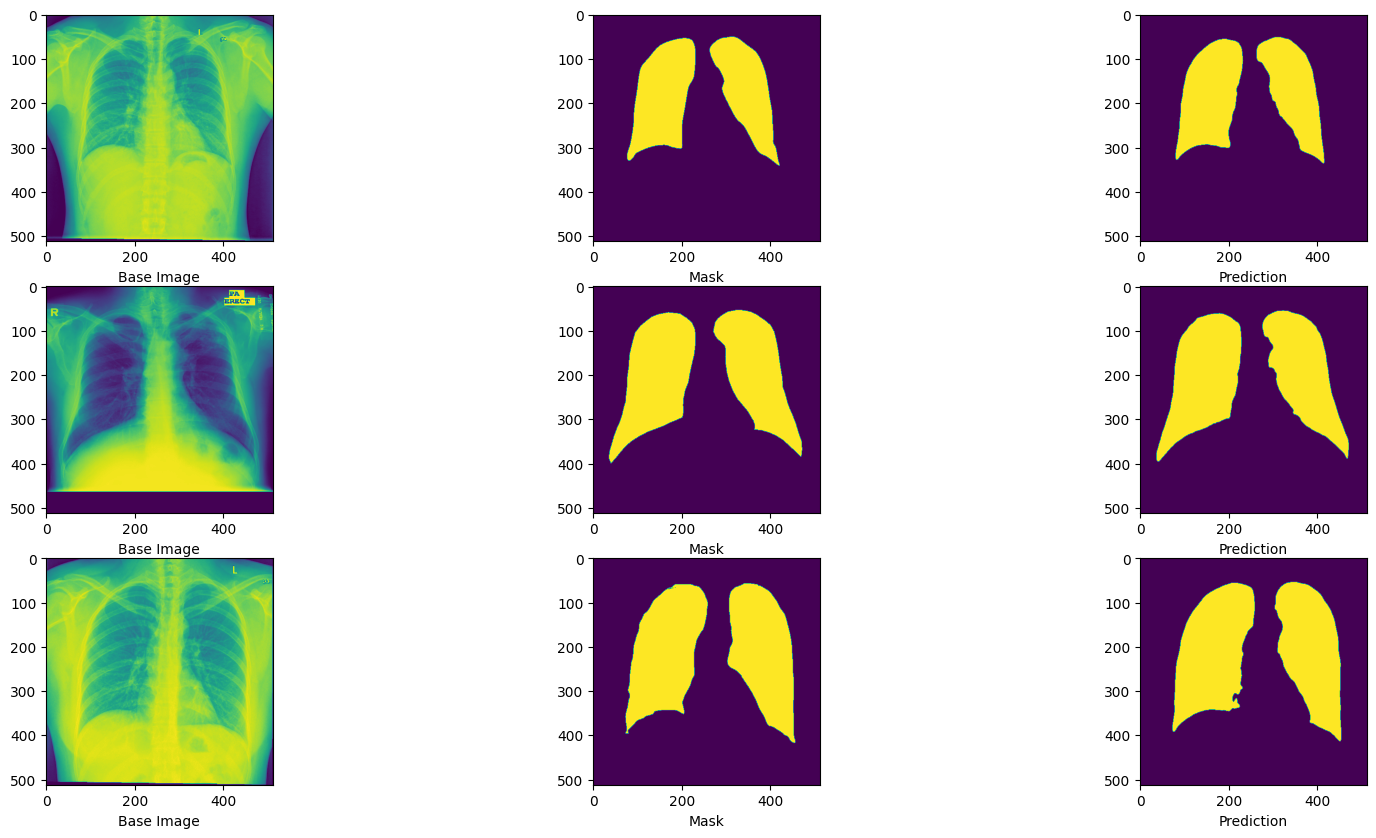

In [ ]:
pred_candidates = np.random.randint(1,test_vol.shape[0],10)
preds = model.predict(test_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)

    plt.imshow(np.squeeze(test_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")


    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(test_seg[pred_candidates[i]]))
    plt.xlabel("Mask")

    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")


# Results

In [ ]:
model.evaluate(test_vol,test_seg)

3/3 [==============================] - 1s 365ms/step - loss: -0.9575 - dice_coef: 0.9604 - binary_accuracy: 0.9788 - iou: 0.9239


[-0.9575408101081848,
 0.9603893756866455,
 0.9788273572921753,
 0.9238548874855042]

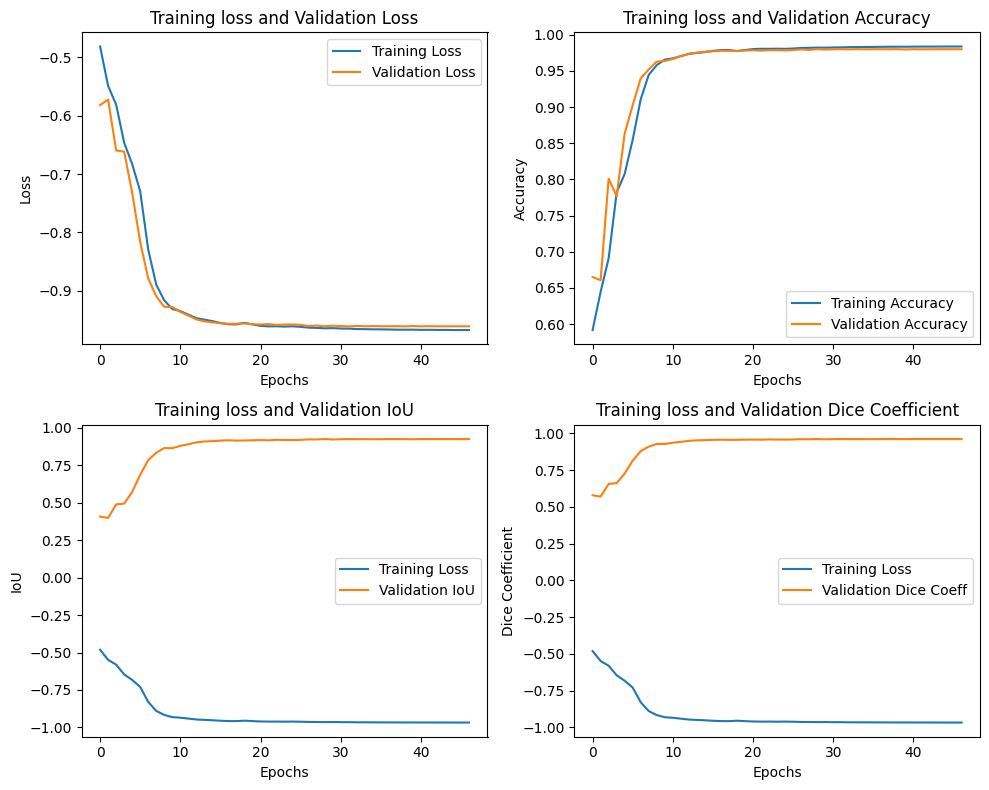

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

ax1.plot(loss_history.history['loss'], label='Training Loss')
ax1.plot(loss_history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training loss and Validation Loss')

ax2.plot(loss_history.history['binary_accuracy'], label='Training Accuracy')
ax2.plot(loss_history.history['val_binary_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training loss and Validation Accuracy')

ax3.plot(loss_history.history['loss'], label='Training Loss')
ax3.plot(loss_history.history['val_iou'], label='Validation IoU')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('IoU')
ax3.legend()
ax3.set_title('Training loss and Validation IoU')

ax4.plot(loss_history.history['loss'], label='Training Loss')
ax4.plot(loss_history.history['val_dice_coef'], label='Validation Dice Coeff')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Dice Coefficient')
ax4.legend()
ax4.set_title('Training loss and Validation Dice Coefficient')

plt.tight_layout()
plt.show()
